#### Library Import

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from numpy.linalg import norm
from sklearn.decomposition import PCA
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Work_to_do

/content/drive/MyDrive/Work_to_do


In [ ]:
# !unzip Face\ Dataset.zip

### 1. Creating the model

In [ ]:
model = VGG16(weights="imagenet", include_top=False)        #Only the feature extraction layers are required.

58889256/58889256 [==============================] - 4s 0us/step


### 2. Auxiliary Functions

#### <p style = "color:red">Extracting image features and resizing the tensors. </p>

In [ ]:
import random

import numpy as np
import torch
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from PIL import Image, ImageEnhance, ImageOps
import warnings
warnings.filterwarnings('ignore')
# def KeepOriginalAug(img):


#   ori_h1,ori_w1,c = img.shape
#   img  = cv2.resize(img, (512, 512))
#   h1,w1,c = img.shape
#   mask_zero = np.zeros((h1,w1, c), img.dtype)


#   beta=1
#   lam = np.random.beta(beta, beta)
#   x1, y1,x2,y2 = saliency_bbox(img, lam)


#   # if no saliency detected, then pick the next image
#   if x1==x2 or y1==y2:
#       return img



#   mask_zero[x1: x2, y1: y2, :] = img[x1: x2, y1: y2,:]


#   sizes= [(w1-((w1-y2)+(y2-y1)), h1-((h1-x2)+(x2-x1))),
#   (w1-((w1-y2)+(y2-y1)), x2-x1),
#   (w1-((w1-y2)+(y2-y1)), h1-x2),
#   (y2-y1, h1-((h1-x2)+(x2-x1))),
#   (y2-y1, h1-x2),
#   (w1-y2, h1-((h1-x2)+(x2-x1))),
#   (w1-y2, x2-x1),
#   (w1-y2, h1-x2)
#   ]
#   areas=[]
#   for sz in sizes:
#       areas.append(sz[0]*sz[1])

#   areas= np.array(areas)
#   sizes = np.array(sizes)


#   big  = 512
#   #  size with its bound box (x1,x2,y1,y2)
#   boxes = [[0,x1,0,y1],
#               [x1,x2,0,y1],
#               [x2,big,0,y1],
#               [0,x1,y1,y2],
#               [x2,big,y1,y2],
#               [0,x1,y2,big],
#               [x1,x2,y2,big],
#               [x2,big,y2,big]
#               ]
#   boxes = np.array(boxes)



#   idx = np.random.choice(list(range(len(areas[areas!=0]))))
#   h2, w2 = sizes[areas!=0][idx]
#   x12, x22, y12,y22= boxes[areas!=0][idx]

#   resized  = cv2.resize(mask_zero[x1: x2, y1: y2, : ], (h2,w2))

#   img = augment(img.copy())
#   img = np.reshape(img, (img.shape[1],img.shape[2],img.shape[3]))
#   resized = augment(resized.copy())
#   resized = np.reshape(resized, (resized.shape[1:]))
#   img[x12: x22, y12: y22] = resized
#   # augment(resized.copy())
#   # self.tensor(self.auto(self.pil(resized)))

#   return cv2.resize(img, (ori_h1,ori_w1))
import numpy as np
import cv2

def KeepOriginalAug(img, aug_strategy='No Aug', area_strategy='max'):
    ori_h1, ori_w1, c = img.shape
    img = cv2.resize(img, (512, 512))
    h1, w1, c = img.shape
    mask_zero = np.zeros((h1, w1, c), img.dtype)

    beta = 1
    lam = np.random.beta(beta, beta)
    x1, y1, x2, y2 = saliency_bbox(img, lam)

    mask_zero[x1: x2, y1: y2, :] = img[x1: x2, y1: y2, :]

    def salient_augmentation(img, mask_zero, x1, y1, x2, y2, aug_strategy, area_strategy):
        sizes = [
            [h1 - ((h1 - y2) + (y2 - y1)), w1 - ((w1 - x2) + (x2 - x1))],
            [h1 - ((h1 - y2) + (y2 - y1)), x2 - x1],
            [h1 - ((h1 - y2) + (y2 - y1)), w1 - x2],
            [y2 - y1, w1 - ((w1 - x2) + (x2 - x1))],
            [y2 - y1, w1 - x2],
            [h1 - y2, w1 - ((w1 - x2) + (x2 - x1))],
            [h1 - y2, x2 - x1],
            [h1 - y2, w1 - x2]
        ]
        areas = [sz[0] * sz[1] for sz in sizes]
        areas = np.array(areas)
        sizes = np.array(sizes)
        big = 512
        boxes = [
            [0, x1, 0, y1],
            [x1, x2, 0, y1],
            [x2, big, 0, y1],
            [0, x1, y1, y2],
            [x2, big, y1, y2],
            [0, x1, y2, big],
            [x1, x2, y2, big],
            [x2, big, y2, big]
        ]
        boxes = np.array(boxes)
        idx = 0
        h2, w2 = 0, 0
        x12, x22, y12, y22 = 0, 0, 0, 0
        # if area_strategy == 'max':
        #     idx = np.argmax(areas)
        #     h2, w2 = sizes[idx]
        #     x12, x22, y12, y22 = boxes[idx]
        # elif area_strategy == 'min':
        #     idx = np.argmin(areas[areas != 0])
        #     h2, w2 = sizes[areas != 0][idx]
        #     x12, x22, y12, y22 = boxes[areas != 0][idx]
        # else:
        idx = np.random.choice(list(range(len(areas[areas != 0]))))
        h2, w2 = sizes[areas != 0][idx]
        x12, x22, y12, y22 = boxes[areas != 0][idx]
        T = cv2.resize(mask_zero[x1: x2, y1: y2, :].copy(), (w2, h2))
        if aug_strategy in ['No Aug', 'Only Original']:
            img[y12: y22, x12: x22] = cv2.resize(T, (x22 - x12, y22 - y12))
        elif aug_strategy in ['Only Salient', 'Both']:
            img[y12: y22, x12: x22] = cv2.resize(augment(T), (x22 - x12, y22 - y12))
        elif aug_strategy == 'Random':
          r = np.random.randint(0, 4)
          if r in [1, 3]:
              img = augment(img)
          elif r in [0, 2]:
              img[y12: y22, x12: x22] = cv2.resize(augment(T), (x22 - x12, y22 - y12))
        return img

    img = salient_augmentation(img, mask_zero, x1, y1, x2, y2, aug_strategy, area_strategy)
    return cv2.resize(img, (ori_h1, ori_w1))


def saliency_bbox(img, lam):
    size = img.shape
    W = size[1]
    H = size[0]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # initialize OpenCV's static fine grained saliency detector and
    # compute the saliency map
    temp_img = img.copy()

    saliency = cv2.saliency.StaticSaliencyFineGrained_create()

    (success, saliencyMap) = saliency.computeSaliency(temp_img)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    maximum_indices = np.unravel_index(np.argmax(saliencyMap, axis=None), saliencyMap.shape)
    x = maximum_indices[0]
    y = maximum_indices[1]

    bbx1 = np.clip(x - cut_w // 2, 0, W)
    bby1 = np.clip(y - cut_h // 2, 0, H)
    bbx2 = np.clip(x + cut_w // 2, 0, W)
    bby2 = np.clip(y + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2



import numpy as np
import albumentations as A


def rand_augment(image, target_size=(512, 512)):
    image = A.Resize(*target_size)(image=image)['image']  # Resize image to fixed size
    num_layers = np.random.randint(1, 4)  # Random number of augmentation layers
    magnitude = np.random.randint(1, 11)  # Random magnitude of augmentation

    # Define a list of augmentations
    augmentations = [
        A.RandomBrightnessContrast(p=0.5),
        A.Blur(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.RandomBrightness(limit=0.2, p=0.5),
        A.RandomContrast(limit=0.2, p=0.5),
        # A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        # A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),
        # A.GridDistortion(p=0.5),
        # A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.5),
        # A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.5),
        # Add more augmentations here
    ]

    # Apply a random set of augmentations with random magnitudes
    for _ in range(num_layers):
        augmentation = np.random.choice(augmentations)
        magnitude_value = np.random.uniform(0.1, 1.0) * magnitude
        image = augmentation(image=image, **augmentation.get_params())['image']

    return image

def augment(images):
    # Convert TensorFlow tensor to NumPy array
    images_np = images

    augmented_images = rand_augment(images_np)
    return augmented_images




def extract_features(img_path, aug_strategy, area_strategy):
    img = image.load_img(img_path, target_size=(650,500))
    x= KeepOriginalAug(image.img_to_array(img).astype('uint8'),aug_strategy, area_strategy)
    # x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return(model.predict(x))


def reduce_dimensions(features):
    # Each image converted to a tensor of size (1x400)
    pca = PCA()
    features = features.reshape(20,15*512)
    pca.fit(features)
    features_trans = pca.transform(features)
    return(np.squeeze(features_trans.reshape(1,400)))

In [ ]:
pip install albumentations

#### Calculating Image Similarity Scores

<li>Image similarity is calculated as cosine similarity of extracted and resized features of two images.</li>
<li>Higher the similarity score, more different the images. Two same images will have a similarity score of 0.</li>
<li>Two types of images similarity scores: <li> <b>Image similarity intra </b> is the mean of image similarity score of every image with all other images in the image set. </li> <li><b>Image similarity cross</b> is the mean of all of the image similarity scores between the images across all the given image sets. </li></li>
<li>Image similarity intra will compare one image set while cross will assess multiple image sets. </li>

In [ ]:
def img_sim_score(features_1, features_2):
    sim = (np.dot(features_1,features_2))/(norm(features_1,2)*norm(features_2,2))
    return(1-sim)

def img_sim_iterator(image_set_1, image_set_2, img_sim_type):
    final_list = []
    if img_sim_type == 'intra' and all(np.array_equal(m, n) for m, n in zip(image_set_1, image_set_2)):
        for i in range(0,len(image_set_1)):
            for j in range(0,len(image_set_2)):
                if not image_set_1[i].all == image_set_2[j].all:
                    final_list.append(img_sim_score(image_set_1[i],image_set_2[j]))
    elif img_sim_type == 'cross' and not (all(np.array_equal(m, n) for m, n in zip(image_set_1, image_set_2))):
        for i in range(0,len(image_set_1)):
            for j in range(0,len(image_set_2)):
                final_list.append(img_sim_score(image_set_1[i],image_set_2[j]))
    return final_list

def img_sim_intra_calculator(image_list,aug_strategy, area_strategy):
    feat_list = []
    for img in image_list:
        feat_list.append(reduce_dimensions(extract_features(img,aug_strategy, area_strategy)))
    return np.mean(img_sim_iterator(feat_list, feat_list, 'intra'))

def img_sim_cross_calculator(image_list,aug_strategy, area_strategy):
    feat_list_combined = []
    for ls in image_list:
        feat_list = []
        for img in ls:
            feat_list.append(reduce_dimensions(extract_features(img,aug_strategy, area_strategy)))
        feat_list_combined.append(feat_list)
    isc_list = []
    for i in range(0,len(feat_list_combined)):
        temp = feat_list_combined.pop()
        for i in range(0,len(feat_list_combined)):
            isc_list.append(np.mean(img_sim_iterator(temp,feat_list_combined[i],'cross')))
    return np.mean(isc_list)

### 3. Calculating Image Similarity Scores

In [ ]:
cd Face\ Dataset

/content/drive/MyDrive/Work_to_do/Face Dataset


### <b style="color:red">General Function to calculate the scores</b>

In [ ]:
def Calculate_intra_cross_score(big_list, profession,aug_strategy, area_strategy):
  for rn in range(1):
    ceo_img_sim_intra_scores_list = []
    for ls in big_list:
        ceo_img_sim_intra_scores_list.append(img_sim_intra_calculator(ls,aug_strategy, area_strategy))

    ceo_img_sim_cross_score = img_sim_cross_calculator(big_list,aug_strategy, area_strategy)
    ceo_img_sim_cross_score_list = [ceo_img_sim_cross_score]*9


    lang_locale_list = ['Arabic-West Asia & North Africa','English-North America','English-West Europe','Hindi-South Asia','Indonesian-SE Asia','Mandarin-East Asia','Russian-East Europe','Spanish-Latin America','Swahili-Sub Saharan Africa']
    column_list = ['Query', 'Lang&Locale','Image_List','ImgSim_Intra','ImgSim_Cross']
    ceo_query_list = [profession]*9
    ceo_df = pd.DataFrame(list(zip(ceo_query_list, lang_locale_list, big_list,ceo_img_sim_intra_scores_list,ceo_img_sim_cross_score_list)),
                  columns = column_list)
    ceo_df.to_csv('./Results_CIKM/hyperparamters/'+profession+'_KeepOriginalAug_'+str(rn)+'.csv')

In [ ]:
# pip install randaugment

### <b style="color:red">CEO</b>

#### Loading the images

In [ ]:
ceo_ar = [f for f in glob(f'Faces/CEO/Arabic/*')]
ceo_engna = [f for f in glob(f'Faces/CEO/English_NA/*')]
ceo_engwe = [f for f in glob(f'Faces/CEO/English_WE/*')]
ceo_hi = [f for f in glob(f'Faces/CEO/Hindi/*')]
ceo_id = [f for f in glob(f'Faces/CEO/Indonesian/*')]
ceo_mnd = [f for f in glob(f'Faces/CEO/Mandarin/*')]
ceo_ru = [f for f in glob(f'Faces/CEO/Russian/*')]
ceo_es = [f for f in glob(f'Faces/CEO/Spanish/*')]
ceo_sw = [f for f in glob(f'Faces/CEO/Swahili/*')]

ceo_list = [ceo_ar,ceo_engna,ceo_engwe,ceo_hi,ceo_id,ceo_mnd,ceo_ru,ceo_es,ceo_sw]
# Assuming 'img' is your loaded image and 'saliency_bbox' is your saliency_bbox() function

aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']

for aug_strategy in aug_strategies:

    for area_strategy in area_strategies:
        Calculate_intra_cross_score(ceo_list, 'CEO'+aug_strategy+"_"+area_strategy, aug_strategy, area_strategy)

1/1 [==============================] - 0s 29ms/step


### <b style="color:red">Engineer</b>

#### Loading the images

In [ ]:
engr_ar = [f for f in glob(f'Faces/Engineer/Arabic/*')]
engr_engna = [f for f in glob(f'Faces/Engineer/English_NA/*')]
engr_engwe = [f for f in glob(f'Faces/Engineer/English_WE/*')]
engr_hi = [f for f in glob(f'Faces/Engineer/Hindi/*')]
engr_id = [f for f in glob(f'Faces/Engineer/Indonesian/*')]
engr_mnd = [f for f in glob(f'Faces/Engineer/Mandarin/*')]
engr_ru = [f for f in glob(f'Faces/Engineer/Russian/*')]
engr_es = [f for f in glob(f'Faces/Engineer/Spanish/*')]
engr_sw = [f for f in glob(f'Faces/Engineer/Swahili/*')]

engr_list = [engr_ar,engr_engna,engr_engwe,engr_hi,engr_id,engr_mnd,engr_ru,engr_es,engr_sw]
aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']

for aug_strategy in aug_strategies:

    for area_strategy in area_strategies:
        Calculate_intra_cross_score(engr_list, 'Engineer'+aug_strategy+"_"+area_strategy, aug_strategy, area_strategy)
        # Calculate_intra_cross_score(engr_list, 'Engineer')

1/1 [==============================] - 0s 29ms/step


### <b style="color:red">Nurse</b>

#### Loading the images

In [ ]:
nur_ar = [f for f in glob(f'Faces/Nurse/Arabic/*')]
nur_engna = [f for f in glob(f'Faces/Nurse/English_NA/*')]
nur_engwe = [f for f in glob(f'Faces/Nurse/English_WE/*')]
nur_hi = [f for f in glob(f'Faces/Nurse/Hindi/*')]
nur_id = [f for f in glob(f'Faces/Nurse/Indonesian/*')]
nur_mnd = [f for f in glob(f'Faces/Nurse/Mandarin/*')]
nur_ru = [f for f in glob(f'Faces/Nurse/Russian/*')]
nur_es = [f for f in glob(f'Faces/Nurse/Spanish/*')]
nur_sw = [f for f in glob(f'Faces/Nurse/Swahili/*')]

nur_list = [nur_ar,nur_engna,nur_engwe,nur_hi,nur_id,nur_mnd,nur_ru,nur_es,nur_sw]
aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']

for aug_strategy in aug_strategies:

    for area_strategy in area_strategies:
        Calculate_intra_cross_score(nur_list, 'Nurse'+aug_strategy+"_"+area_strategy, aug_strategy, area_strategy)

# Calculate_intra_cross_score(nur_list, 'Nurse')


1/1 [==============================] - 3s 3s/step


### <b style="color:red">Politician</b>

#### Loading the images

In [ ]:
pol_ar = [f for f in glob(f'Faces/Politician/Arabic/*')]
pol_engna = [f for f in glob(f'Faces/Politician/English_NA/*')]
pol_engwe = [f for f in glob(f'Faces/Politician/English_WE/*')]
pol_hi = [f for f in glob(f'Faces/Politician/Hindi/*')]
pol_id = [f for f in glob(f'Faces/Politician/Indonesian/*')]
pol_mnd = [f for f in glob(f'Faces/Politician/Mandarin/*')]
pol_ru = [f for f in glob(f'Faces/Politician/Russian/*')]
pol_es = [f for f in glob(f'Faces/Politician/Spanish/*')]
pol_sw = [f for f in glob(f'Faces/Politician/Swahili/*')]

pol_list = [pol_ar,pol_engna,pol_engwe,pol_hi,pol_id,pol_mnd,pol_ru,pol_es,pol_sw]
aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']

for aug_strategy in aug_strategies:

    for area_strategy in area_strategies:
        Calculate_intra_cross_score(pol_list, 'Politician'+aug_strategy+"_"+area_strategy, aug_strategy, area_strategy)

# Calculate_intra_cross_score(pol_list, 'Politician')


1/1 [==============================] - 0s 20ms/step


### <b style="color:red">School Teacher</b>

#### Loading the images

In [ ]:
st_ar = [f for f in glob(f'Faces/School Teacher/Arabic/*')]
st_engna = [f for f in glob(f'Faces/School Teacher/English_NA/*')]
st_engwe = [f for f in glob(f'Faces/School Teacher/English_WE/*')]
st_hi = [f for f in glob(f'Faces/School Teacher/Hindi/*')]
st_id = [f for f in glob(f'Faces/School Teacher/Indonesian/*')]
st_mnd = [f for f in glob(f'Faces/School Teacher/Mandarin/*')]
st_ru = [f for f in glob(f'Faces/School Teacher/Russian/*')]
st_es = [f for f in glob(f'Faces/School Teacher/Spanish/*')]
st_sw = [f for f in glob(f'Faces/School Teacher/Swahili/*')]
st_list = [st_ar,st_engna,st_engwe,st_hi,st_id,st_mnd,st_ru,st_es,st_sw]
aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']
for aug_strategy in aug_strategies:
    for area_strategy in area_strategies:
        Calculate_intra_cross_score(st_list, 'School Teacher'+aug_strategy+"_"+area_strategy, aug_strategy, area_strategy)
# Calculate_intra_cross_score(st_list, 'School Teacher')

1/1 [==============================] - 0s 21ms/step


## Plotting of ISS-Intra

In [ ]:
import pandas as pd
import numpy as np
import os
path = '/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/'


aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']
professions = ['CEO', 'Nurse', 'Engineer', 'School Teacher','Politician']
# , 'Engineer', 'Nurse', 'Politician']
data = {}
for prof in professions:
  overall_intra=[]
  overall_cross = []
  data={}
  for aug_strategy in aug_strategies:
    for area_strategy in area_strategies:
      count=0
      # print(os.listdir(pth))
      fl = prof+aug_strategy+"_"+area_strategy+'_KeepOriginalAug_'+str(0)+'.csv'
      print(path+fl)
      df = pd.read_csv(path+fl)
      print(prof,aug_strategy, area_strategy, df['ImgSim_Intra'].mean())
      print(df['ImgSim_Cross'].mean())
      data[aug_strategy, area_strategy]= [np.round(df['ImgSim_Intra'].mean(), 4)]
      # ,np.round(df['ImgSim_Cross'].mean(),4)]
      overall_intra.append(np.round(df['ImgSim_Intra'].mean(), 4))
      overall_cross.append(np.round(df['ImgSim_Cross'].mean(),4))
  print('Overall Mean')
  print(round(np.mean(overall_intra),4), round(np.mean(overall_cross),4))
  import pandas as pd
  import matplotlib.pyplot as plt

  # Given data


  # Convert data to DataFrame
  df = pd.DataFrame(data).T.reset_index()
  df.columns = ['Method', 'Area Strategy', 'Augmentation Strategy']

  # Pivot the DataFrame to have probability values as columns
  df_pivot = df.pivot(index='Method', columns='Area Strategy', values='Augmentation Strategy')

  # Plotting
  plt.rcParams.update({'font.size': 22})

  # Plot grouped bar chart
  df_pivot.plot(kind='bar', figsize=(20, 8))
  plt.title('Placement and Augment strategies for '+prof, fontweight='bold', fontsize=15)
  plt.xlabel("Augmentation strategy", fontsize=15, fontweight='bold')
  plt.ylabel("Imagem Similarity Score - Intra ", fontsize=15, fontweight='bold')
  plt.legend(title='Area Strategy', loc='lower left', fontsize=16)
  plt.xticks(rotation=0)
  plt.savefig('Intra-Hyperparameter-pdfs/'+prof +'Placement and Augment strategies.pdf')


## Plotting of ISS-Inter

/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Original_max_KeepOriginalAug_0.csv
CEO Only Original max 0.9927860869436785
0.9932046686623033
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Original_min_KeepOriginalAug_0.csv
CEO Only Original min 0.9934511381106267
0.995936466926355
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Original_random_KeepOriginalAug_0.csv
CEO Only Original random 0.9887145991899394
0.9945387508508817
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Salient_max_KeepOriginalAug_0.csv
CEO Only Salient max 0.9932787485151611
0.9960065867972092
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Salient_min_KeepOriginalAug_0.csv
CEO Only Salient min 0.9913364910999619
0.9935322915282873
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Salient_random_KeepOrigina

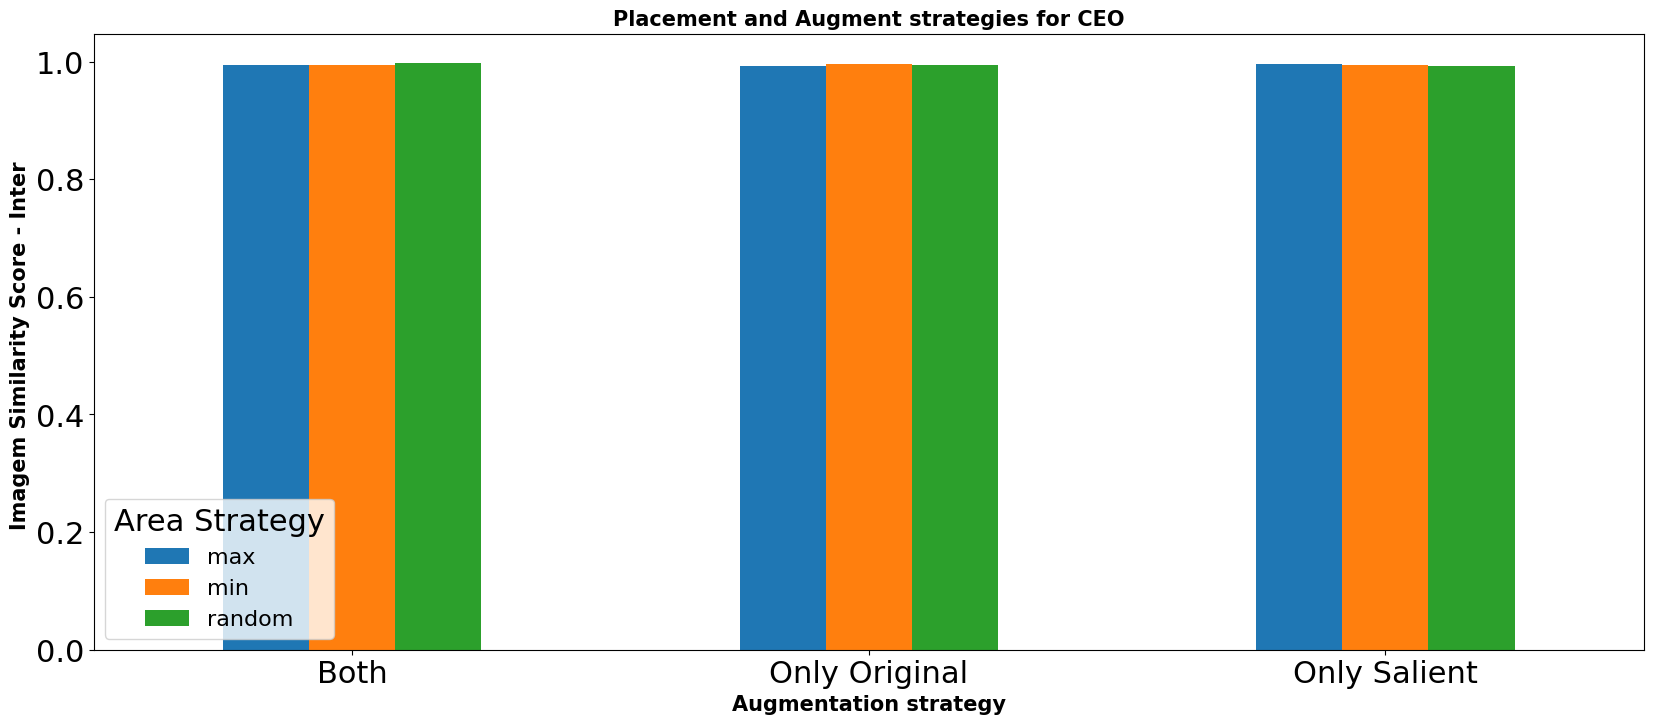

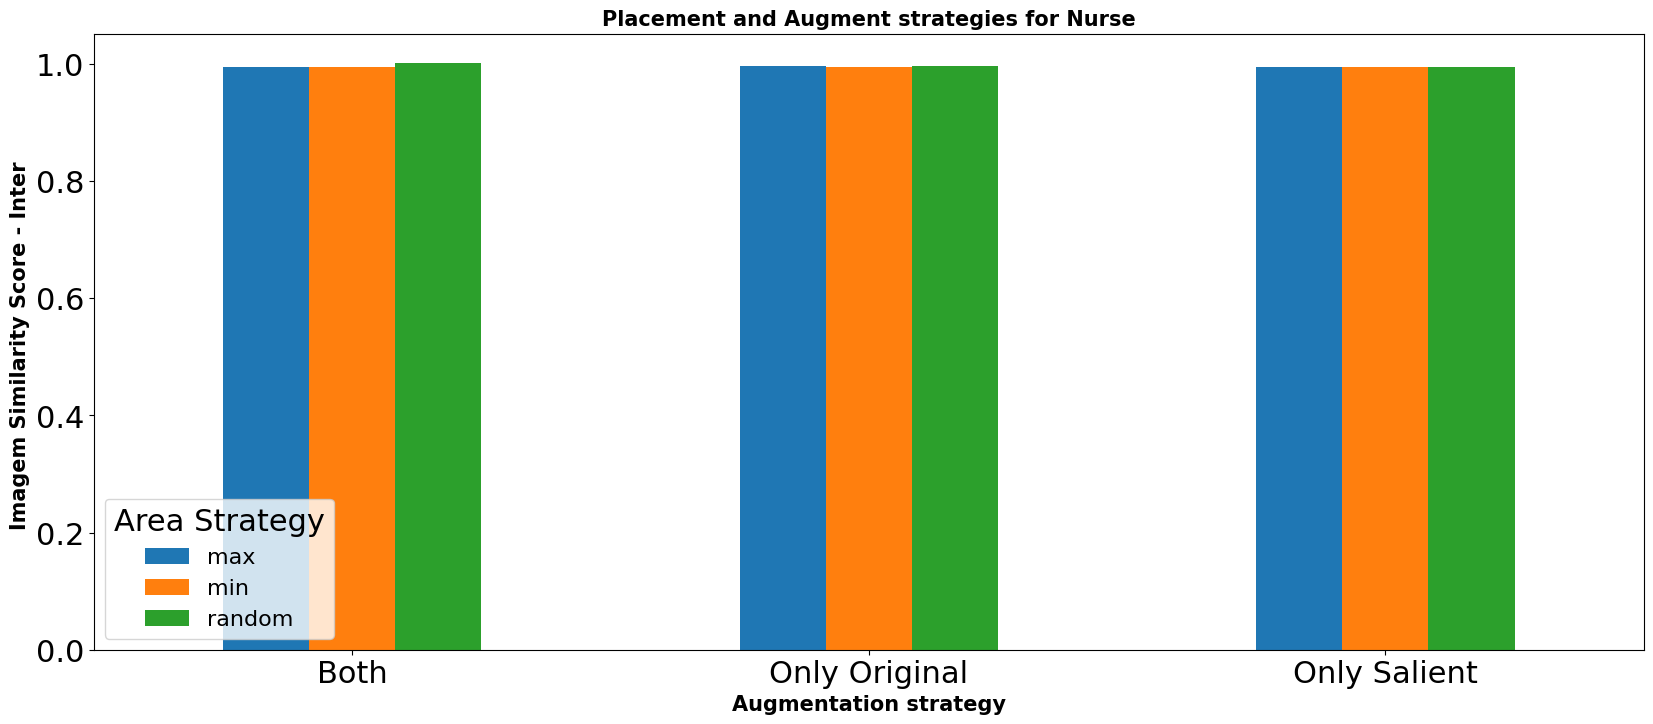

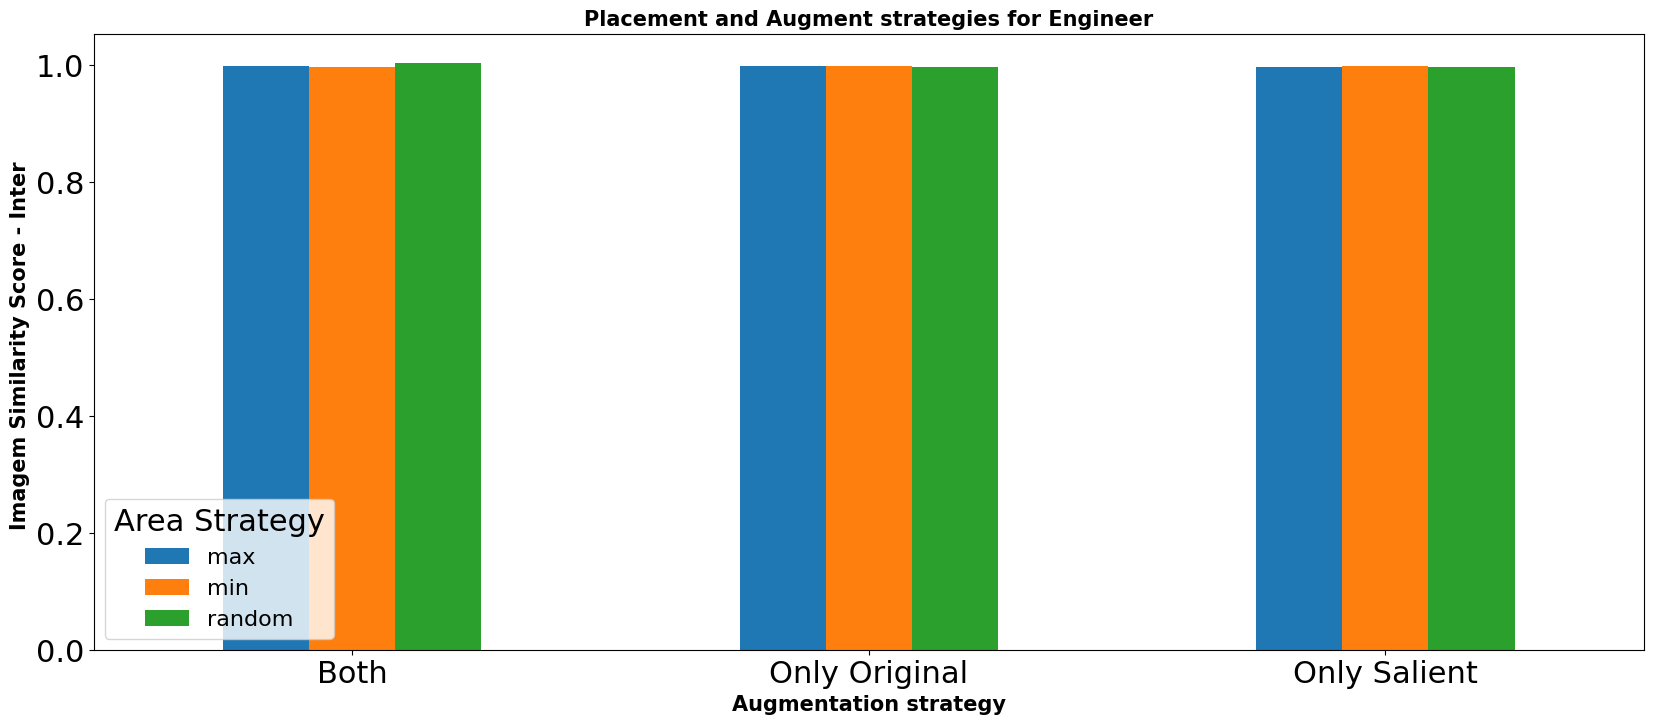

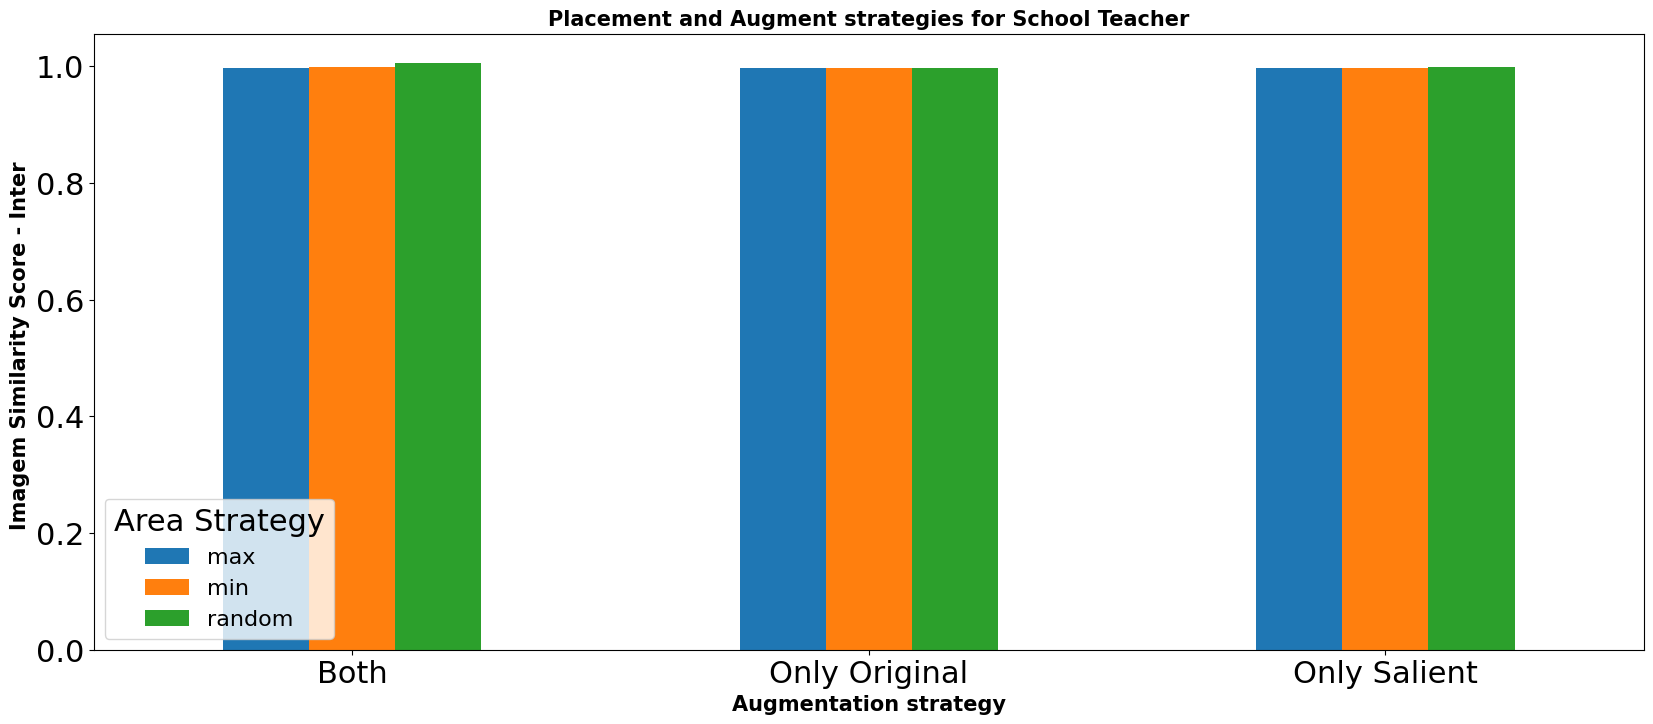

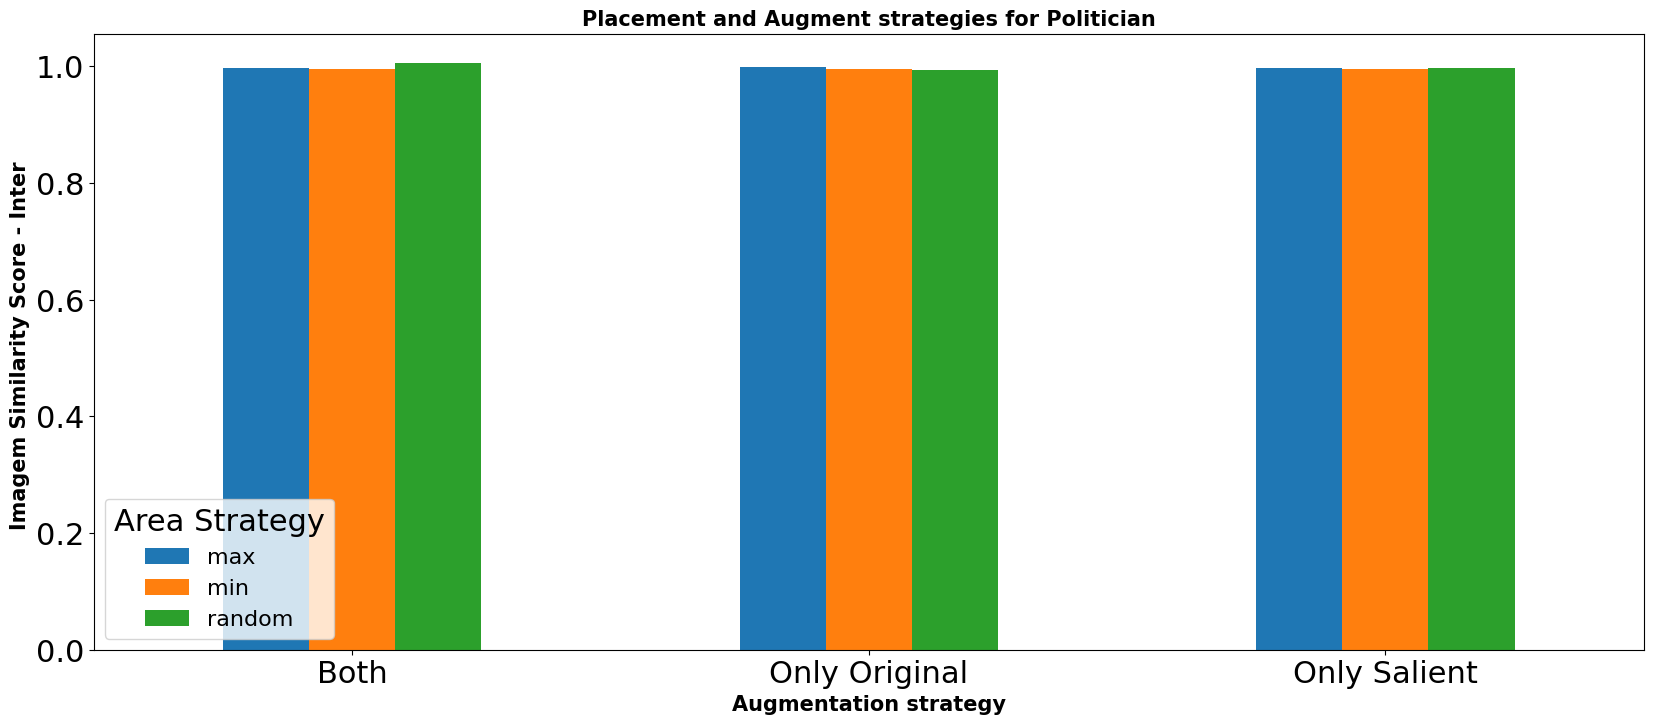

In [ ]:
import pandas as pd
import numpy as np
import os
path = '/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/'


aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']
professions = ['CEO', 'Nurse', 'Engineer', 'School Teacher','Politician']
# , 'Engineer', 'Nurse', 'Politician']
data = {}
for prof in professions:
  overall_intra=[]
  overall_cross = []
  data={}
  for aug_strategy in aug_strategies:
    for area_strategy in area_strategies:
      count=0
      # print(os.listdir(pth))
      fl = prof+aug_strategy+"_"+area_strategy+'_KeepOriginalAug_'+str(0)+'.csv'
      print(path+fl)
      df = pd.read_csv(path+fl)
      print(prof,aug_strategy, area_strategy, df['ImgSim_Intra'].mean())
      print(df['ImgSim_Cross'].mean())
      data[aug_strategy, area_strategy]= [np.round(df['ImgSim_Cross'].mean(), 4)]
      # ,np.round(df['ImgSim_Cross'].mean(),4)]
      overall_intra.append(np.round(df['ImgSim_Intra'].mean(), 4))
      overall_cross.append(np.round(df['ImgSim_Cross'].mean(),4))
  print('Overall Mean')
  print(round(np.mean(overall_intra),4), round(np.mean(overall_cross),4))
  import pandas as pd
  import matplotlib.pyplot as plt

  # Given data


  # Convert data to DataFrame
  df = pd.DataFrame(data).T.reset_index()
  df.columns = ['Method', 'Area Strategy', 'Augmentation Strategy']

  # Pivot the DataFrame to have probability values as columns
  df_pivot = df.pivot(index='Method', columns='Area Strategy', values='Augmentation Strategy')

  # Plotting
  plt.rcParams.update({'font.size': 22})

  # Plot grouped bar chart
  df_pivot.plot(kind='bar', figsize=(20, 8))
  plt.title('Placement and Augment strategies for '+prof, fontweight='bold', fontsize=15)
  plt.xlabel("Augmentation strategy", fontsize=15, fontweight='bold')
  plt.ylabel("Imagem Similarity Score - Inter ", fontsize=15, fontweight='bold')
  plt.legend(title='Area Strategy', loc='lower left', fontsize=16)
  plt.xticks(rotation=0)
  plt.savefig('Inter-Hyperparameter-pdfs/'+prof +'Placement and Augment strategies.pdf')


In [ ]:
!zip -r Inter-Hyperparameter-pdfs.zip Inter-Hyperparameter-pdfs

updating: Inter-Hyperparameter-pdfs/ (stored 0%)
  adding: Inter-Hyperparameter-pdfs/.zip (stored 0%)
  adding: Inter-Hyperparameter-pdfs/CEOPlacement and Augment strategies.pdf (deflated 34%)
  adding: Inter-Hyperparameter-pdfs/NursePlacement and Augment strategies.pdf (deflated 34%)
  adding: Inter-Hyperparameter-pdfs/School TeacherPlacement and Augment strategies.pdf (deflated 34%)
  adding: Inter-Hyperparameter-pdfs/EngineerPlacement and Augment strategies.pdf (deflated 34%)
  adding: Inter-Hyperparameter-pdfs/PoliticianPlacement and Augment strategies.pdf (deflated 34%)


In [ ]:
!zip -r Intra-Hyperparameter-pdfs.zip Intra-Hyperparameter-pdfs

  adding: Intra-Hyperparameter-pdfs/ (stored 0%)
  adding: Intra-Hyperparameter-pdfs/CEOPlacement and Augment strategies.pdf (deflated 34%)
  adding: Intra-Hyperparameter-pdfs/NursePlacement and Augment strategies.pdf (deflated 34%)
  adding: Intra-Hyperparameter-pdfs/School TeacherPlacement and Augment strategies.pdf (deflated 34%)
  adding: Intra-Hyperparameter-pdfs/EngineerPlacement and Augment strategies.pdf (deflated 34%)
  adding: Intra-Hyperparameter-pdfs/PoliticianPlacement and Augment strategies.pdf (deflated 34%)


In [ ]:
import pandas as pd
import numpy as np
import os
path = '/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/'


aug_strategies = ['Only Original', 'Only Salient', 'Both']
area_strategies = ['max', 'min', 'random']
professions = ['CEO', 'Nurse', 'Engineer', 'School Teacher','Politician']
# , 'Engineer', 'Nurse', 'Politician']
data = {}
for prof in professions:
  overall_intra=[]
  overall_cross = []
  data[prof]={}
  for aug_strategy in aug_strategies:
    data[prof][aug_strategy]={}
    for area_strategy in area_strategies:
      count=0
      # print(os.listdir(pth))
      fl = prof+aug_strategy+"_"+area_strategy+'_KeepOriginalAug_'+str(0)+'.csv'
      print(path+fl)
      df = pd.read_csv(path+fl)
      # print(prof,aug_strategy, area_strategy, df['ImgSim_Intra'].mean())
      print(df['ImgSim_Cross'].mean())

      data[prof][aug_strategy][area_strategy]= [np.round(df['ImgSim_Intra'].mean(), 4),np.round(df['ImgSim_Cross'].mean(),4)]


      # ,np.round(df['ImgSim_Cross'].mean(),4)]
      overall_intra.append(np.round(df['ImgSim_Intra'].mean(), 4))
      overall_cross.append(np.round(df['ImgSim_Cross'].mean(),4))
  # print('Overall Mean')
  # print(round(np.mean(overall_intra),4), round(np.mean(overall_cross),4))
  data

/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Original_max_KeepOriginalAug_0.csv
0.9932046686623033
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Original_min_KeepOriginalAug_0.csv
0.995936466926355
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Original_random_KeepOriginalAug_0.csv
0.9945387508508817
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Salient_max_KeepOriginalAug_0.csv
0.9960065867972092
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Salient_min_KeepOriginalAug_0.csv
0.9935322915282873
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOOnly Salient_random_KeepOriginalAug_0.csv
0.9926190947999094
/content/drive/MyDrive/Work_to_do/Face Dataset/Results_CIKM/hyperparamters/CEOBoth_max_KeepOriginalAug_0.csv
0.9946321065147943
/content/drive/MyDrive/Work_to_do/Face Dataset/R

In [ ]:

import json



# Write data to JSON file
with open('/content/Hyperparameter_overall_results.json', 'w') as f:
    json.dump(data, f, indent=4)

print("Data has been written to output.json")


Data has been written to output.json


In [ ]:
pip install randaugment

Augmented image saved successfully!


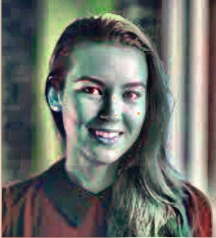

In [ ]:
import cv2
import albumentations as A

import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load the input image
input_image_path = "/content/input.jpg"
input_image = cv2.imread(input_image_path)


input_image = cv2.imread(input_image_path)


# Define augmentation sequence with multiple techniques

# Define augmentation sequence with multiple techniques
seq = iaa.Sequential([
    # iaa.Fliplr(0.5),  # Horizontal flips
    # iaa.Flipud(0.5),  # Vertical flips
    # iaa.Rotate((-45, 45)),  # Rotate images
    # iaa.GaussianBlur(sigma=(0, 3.0)),  # Gaussian blur
    # iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),  # Gaussian noise
    # iaa.Multiply((0.8, 1.2)),  # Brightness changes
    iaa.ContrastNormalization((0.5, 1.5)),  # Contrast changes
    # iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # Sharpen images
    # iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),  # Elastic transformation
        iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True),  # Multiply hue and saturation
    iaa.SigmoidContrast(gain=(3, 5), cutoff=(0.4, 0.6)),  # Sigmoid contrast
        iaa.ChangeColorTemperature((1100, 10000)),  # Change color temperature
    iaa.LinearContrast((0.5, 2.0), per_channel=True),  # Linear contrast adjustment
    iaa.AllChannelsCLAHE(clip_limit=(1, 10)),  # Apply CLAHE to all channels
    iaa.ChannelShuffle(p=1.0),  # Shuffle color channels
    ])

augmented_image = seq(image=input_image)

# Retrieve augmented image
augmented_image = augmented_image.astype('uint8')


# Save the augmented image
output_image_path = "/content/output_image.jpg"
cv2.imwrite(output_image_path, augmented_image)

print("Augmented image saved successfully!")
cv2_imshow(augmented_image)

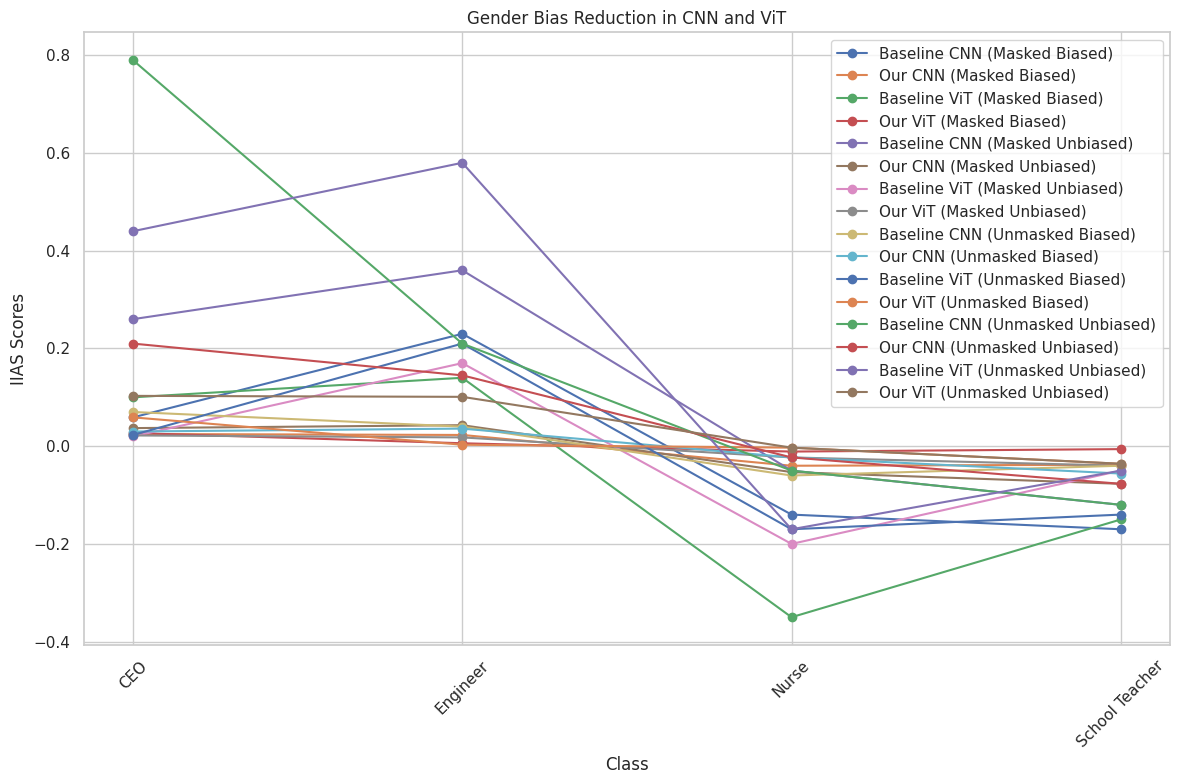

In [ ]:
import matplotlib.pyplot as plt

# IIAS scores for CNN and ViT in the masked biased scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']
baseline_CNN_masked_biased = [0.059, 0.23, -0.14, -0.17]
ours_CNN_masked_biased = [0.025, 0.023, -0.040, -0.038]
baseline_ViT_masked_biased = [0.1, 0.14, -0.35, -0.15]
ours_ViT_masked_biased = [0.027, 0.006, -0.011, -0.006]

# IIAS scores for CNN and ViT in the masked unbiased scenario
baseline_CNN_masked_unbiased = [0.26, 0.36, -0.05, -0.12]
ours_CNN_masked_unbiased = [0.037, 0.043, -0.053, -0.077]
baseline_ViT_masked_unbiased = [0.02, 0.17, -0.2, -0.05]
ours_ViT_masked_unbiased = [0.022, 0.018, -0.023, -0.04]

# IIAS scores for CNN and ViT in the unmasked biased scenario
baseline_CNN_unmasked_biased = [0.07, 0.04, -0.06, -0.04]
ours_CNN_unmasked_biased = [0.03, 0.036, -0.023, -0.056]
baseline_ViT_unmasked_biased = [0.023, 0.21, -0.17, -0.14]
ours_ViT_unmasked_biased = [0.059, 0.003, -0.003, -0.036]

# IIAS scores for CNN and ViT in the unmasked unbiased scenario
baseline_CNN_unmasked_unbiased = [0.79, 0.21, -0.05, -0.12]
ours_CNN_unmasked_unbiased = [0.21, 0.145, -0.023, -0.077]
baseline_ViT_unmasked_unbiased = [0.44, 0.58, -0.17, -0.05]
ours_ViT_unmasked_unbiased = [0.103, 0.101, -0.003, -0.036]

# Plotting for all scenarios
plt.figure(figsize=(12, 8))

# Plotting masked biased scenario
plt.plot(classes, baseline_CNN_masked_biased, marker='o', label='Baseline CNN (Masked Biased)')
plt.plot(classes, ours_CNN_masked_biased, marker='o', label='Our CNN (Masked Biased)')
plt.plot(classes, baseline_ViT_masked_biased, marker='o', label='Baseline ViT (Masked Biased)')
plt.plot(classes, ours_ViT_masked_biased, marker='o', label='Our ViT (Masked Biased)')

# Plotting masked unbiased scenario
plt.plot(classes, baseline_CNN_masked_unbiased, marker='o', label='Baseline CNN (Masked Unbiased)')
plt.plot(classes, ours_CNN_masked_unbiased, marker='o', label='Our CNN (Masked Unbiased)')
plt.plot(classes, baseline_ViT_masked_unbiased, marker='o', label='Baseline ViT (Masked Unbiased)')
plt.plot(classes, ours_ViT_masked_unbiased, marker='o', label='Our ViT (Masked Unbiased)')

# Plotting unmasked biased scenario
plt.plot(classes, baseline_CNN_unmasked_biased, marker='o', label='Baseline CNN (Unmasked Biased)')
plt.plot(classes, ours_CNN_unmasked_biased, marker='o', label='Our CNN (Unmasked Biased)')
plt.plot(classes, baseline_ViT_unmasked_biased, marker='o', label='Baseline ViT (Unmasked Biased)')
plt.plot(classes, ours_ViT_unmasked_biased, marker='o', label='Our ViT (Unmasked Biased)')

# Plotting unmasked unbiased scenario
plt.plot(classes, baseline_CNN_unmasked_unbiased, marker='o', label='Baseline CNN (Unmasked Unbiased)')
plt.plot(classes, ours_CNN_unmasked_unbiased, marker='o', label='Our CNN (Unmasked Unbiased)')
plt.plot(classes, baseline_ViT_unmasked_unbiased, marker='o', label='Baseline ViT (Unmasked Unbiased)')
plt.plot(classes, ours_ViT_unmasked_unbiased, marker='o', label='Our ViT (Unmasked Unbiased)')

plt.title('Gender Bias Reduction in CNN and ViT')
plt.xlabel('Class')
plt.ylabel('IIAS Scores')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# ECAI fairness workshop - KeepOriginalAugment


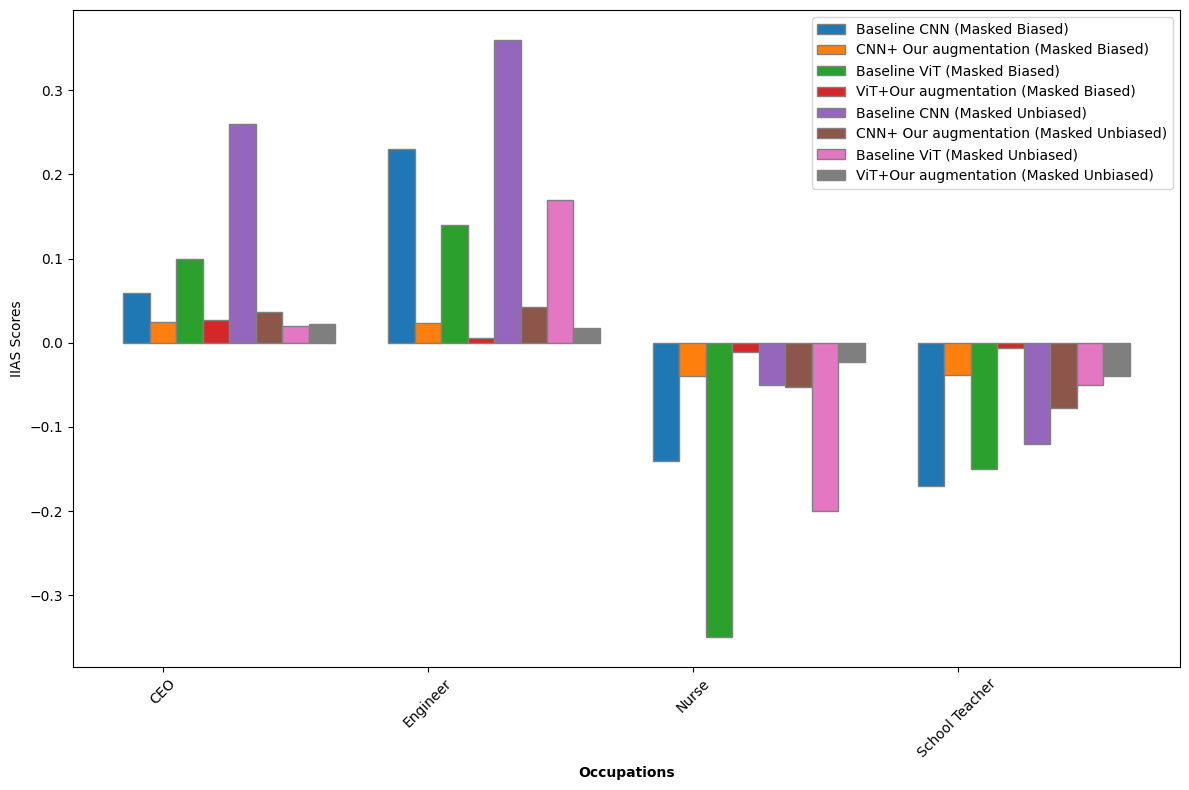

In [ ]:
import matplotlib.pyplot as plt

# IIAS scores for CNN and ViT in the masked biased scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']
baseline_CNN_masked_biased = [0.059, 0.23, -0.14, -0.17]
ours_CNN_masked_biased = [0.025, 0.023, -0.040, -0.038]
baseline_ViT_masked_biased = [0.1, 0.14, -0.35, -0.15]
ours_ViT_masked_biased = [0.027, 0.006, -0.011, -0.006]

# IIAS scores for CNN and ViT in the masked unbiased scenario
baseline_CNN_masked_unbiased = [0.26, 0.36, -0.05, -0.12]
ours_CNN_masked_unbiased = [0.037, 0.043, -0.053, -0.077]
baseline_ViT_masked_unbiased = [0.02, 0.17, -0.2, -0.05]
ours_ViT_masked_unbiased = [0.022, 0.018, -0.023, -0.04]

# IIAS scores for CNN and ViT in the unmasked biased scenario
baseline_CNN_unmasked_biased = [0.07, 0.04, -0.06, -0.04]
ours_CNN_unmasked_biased = [0.03, 0.036, -0.023, -0.056]
baseline_ViT_unmasked_biased = [0.023, 0.21, -0.17, -0.14]
ours_ViT_unmasked_biased = [0.059, 0.003, -0.003, -0.036]

# IIAS scores for CNN and ViT in the unmasked unbiased scenario
baseline_CNN_unmasked_unbiased = [0.79, 0.21, -0.05, -0.12]
ours_CNN_unmasked_unbiased = [0.21, 0.145, -0.023, -0.077]
baseline_ViT_unmasked_unbiased = [0.44, 0.58, -0.17, -0.05]
ours_ViT_unmasked_unbiased = [0.103, 0.101, -0.003, -0.036]

# Setting width of bar
barWidth = 0.1

# Set position of bar on X axis
r1 = range(len(classes))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]


# Make the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, baseline_CNN_masked_biased, width=barWidth, edgecolor='grey', label='Baseline CNN (Masked Biased)')
plt.bar(r2, ours_CNN_masked_biased, width=barWidth, edgecolor='grey', label='CNN+ Our augmentation (Masked Biased)')
plt.bar(r3, baseline_ViT_masked_biased, width=barWidth, edgecolor='grey', label='Baseline ViT (Masked Biased)')
plt.bar(r4, ours_ViT_masked_biased, width=barWidth, edgecolor='grey', label='ViT+Our augmentation (Masked Biased)')
plt.bar(r5, baseline_CNN_masked_unbiased, width=barWidth, edgecolor='grey', label='Baseline CNN (Masked Unbiased)')
plt.bar(r6, ours_CNN_masked_unbiased, width=barWidth, edgecolor='grey', label='CNN+ Our augmentation (Masked Unbiased)')
plt.bar(r7, baseline_ViT_masked_unbiased, width=barWidth, edgecolor='grey', label='Baseline ViT (Masked Unbiased)')
plt.bar(r8, ours_ViT_masked_unbiased, width=barWidth, edgecolor='grey', label='ViT+Our augmentation (Masked Unbiased)')


# Add xticks on the middle of the group bars
plt.xlabel('Occupations', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(classes))], classes)

# Create legend & Show graphic
plt.legend()
# plt.title('Gender Bias Reduction in CNN and ViT (Masked)')
plt.ylabel('IIAS Scores')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('gender_masked_reduction.jpeg', format='jpeg', dpi=300)
plt.show()


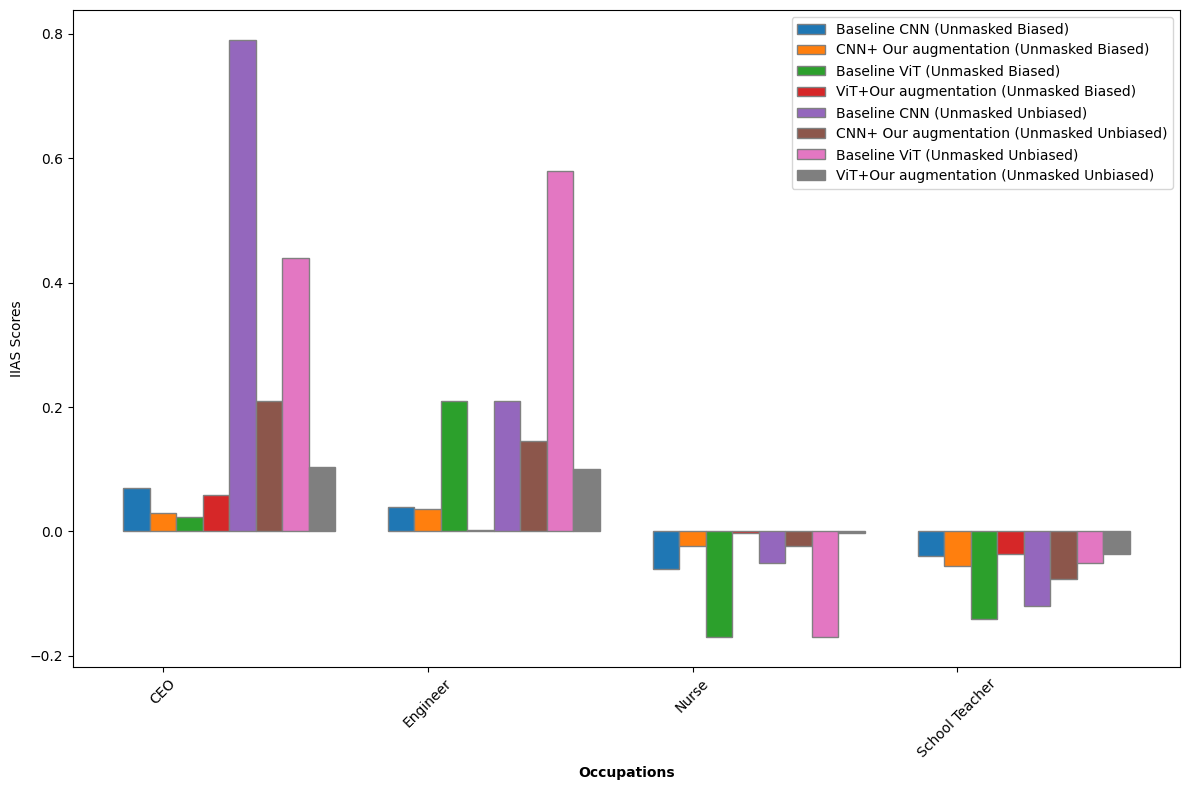

In [ ]:
import matplotlib.pyplot as plt

# IIAS scores for CNN and ViT in the masked biased scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']
baseline_CNN_masked_biased = [0.059, 0.23, -0.14, -0.17]
ours_CNN_masked_biased = [0.025, 0.023, -0.040, -0.038]
baseline_ViT_masked_biased = [0.1, 0.14, -0.35, -0.15]
ours_ViT_masked_biased = [0.027, 0.006, -0.011, -0.006]

# IIAS scores for CNN and ViT in the masked unbiased scenario
baseline_CNN_masked_unbiased = [0.26, 0.36, -0.05, -0.12]
ours_CNN_masked_unbiased = [0.037, 0.043, -0.053, -0.077]
baseline_ViT_masked_unbiased = [0.02, 0.17, -0.2, -0.05]
ours_ViT_masked_unbiased = [0.022, 0.018, -0.023, -0.04]

# IIAS scores for CNN and ViT in the unmasked biased scenario
baseline_CNN_unmasked_biased = [0.07, 0.04, -0.06, -0.04]
ours_CNN_unmasked_biased = [0.03, 0.036, -0.023, -0.056]
baseline_ViT_unmasked_biased = [0.023, 0.21, -0.17, -0.14]
ours_ViT_unmasked_biased = [0.059, 0.003, -0.003, -0.036]

# IIAS scores for CNN and ViT in the unmasked unbiased scenario
baseline_CNN_unmasked_unbiased = [0.79, 0.21, -0.05, -0.12]
ours_CNN_unmasked_unbiased = [0.21, 0.145, -0.023, -0.077]
baseline_ViT_unmasked_unbiased = [0.44, 0.58, -0.17, -0.05]
ours_ViT_unmasked_unbiased = [0.103, 0.101, -0.003, -0.036]

# Setting width of bar
barWidth = 0.1

# Set position of bar on X axis
r1 = range(len(classes))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]


# Make the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, baseline_CNN_unmasked_biased, width=barWidth, edgecolor='grey', label='Baseline CNN (Unmasked Biased)')
plt.bar(r2, ours_CNN_unmasked_biased, width=barWidth, edgecolor='grey', label='CNN+ Our augmentation (Unmasked Biased)')
plt.bar(r3, baseline_ViT_unmasked_biased, width=barWidth, edgecolor='grey', label='Baseline ViT (Unmasked Biased)')
plt.bar(r4, ours_ViT_unmasked_biased, width=barWidth, edgecolor='grey', label='ViT+Our augmentation (Unmasked Biased)')
plt.bar(r5, baseline_CNN_unmasked_unbiased, width=barWidth, edgecolor='grey', label='Baseline CNN (Unmasked Unbiased)')
plt.bar(r6, ours_CNN_unmasked_unbiased, width=barWidth, edgecolor='grey', label='CNN+ Our augmentation (Unmasked Unbiased)')
plt.bar(r7, baseline_ViT_unmasked_unbiased, width=barWidth, edgecolor='grey', label='Baseline ViT (Unmasked Unbiased)')
plt.bar(r8, ours_ViT_unmasked_unbiased, width=barWidth, edgecolor='grey', label='ViT+Our augmentation (Unmasked Unbiased)')


# Add xticks on the middle of the group bars
plt.xlabel('Occupations', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(classes))], classes)

# Create legend & Show graphic
plt.legend()
# plt.title('Gender Bias Reduction in CNN and ViT (Unmasked)')
plt.ylabel('IIAS Scores')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('gender_unmasked_reduction.jpeg', format='jpeg', dpi=300)
plt.show()


##ECAI workshop Tabular results to figures

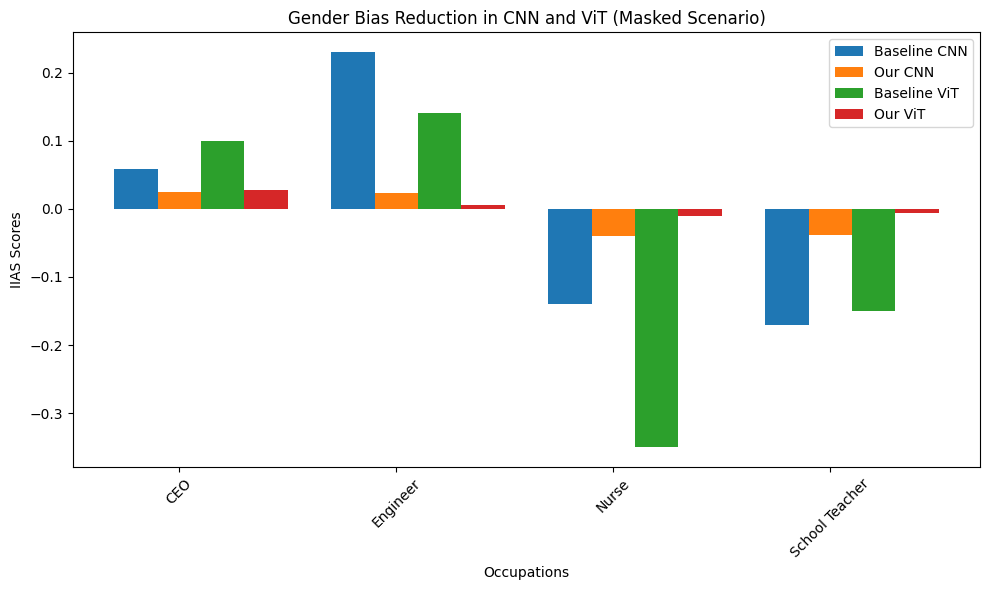

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# IIAS scores for CNN and ViT in the masked scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']

# Define IIAS scores for each model in the masked scenario
baseline_CNN_masked_biased = [0.059, 0.23, -0.14, -0.17]
ours_CNN_masked_biased = [0.025, 0.023, -0.040, -0.038]
baseline_ViT_masked_biased = [0.1, 0.14, -0.35, -0.15]
ours_ViT_masked_biased = [0.027, 0.006, -0.011, -0.006]

# Set the width of the bars
bar_width = 0.2

# Set the position of each bar on the x-axis
baseline_positions = np.arange(len(classes))
ours_positions = [x + bar_width for x in baseline_positions]

# Plotting for masked scenario
plt.figure(figsize=(10, 6))

plt.bar(baseline_positions, baseline_CNN_masked_biased, bar_width, label='Baseline CNN')
plt.bar(ours_positions, ours_CNN_masked_biased, bar_width, label='CNN+Our Augmentation')

plt.bar([x + 2 * bar_width for x in baseline_positions], baseline_ViT_masked_biased, bar_width, label='Baseline ViT')
plt.bar([x + 3 * bar_width for x in baseline_positions], ours_ViT_masked_biased, bar_width, label='Our ViT')

# Add labels, title, and legend
plt.xlabel('Occupations')
plt.ylabel('IIAS Scores')
plt.title('Gender Bias Reduction in CNN and ViT (Masked Scenario)')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)  # Remove the grid
plt.tight_layout()
plt.savefig('masked_bias_reduction.pdf', dpi=1000)
# Show the plot
plt.show()


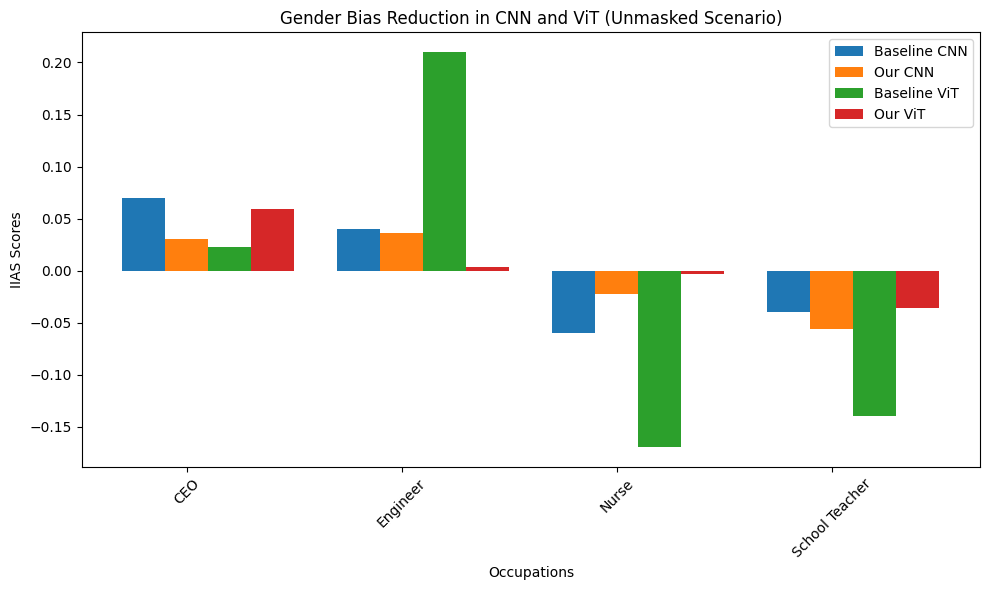

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# IIAS scores for CNN and ViT in the unmasked scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']

# Define IIAS scores for each model in the unmasked scenario
baseline_CNN_unmasked_biased = [0.07, 0.04, -0.06, -0.04]
ours_CNN_unmasked_biased = [0.03, 0.036, -0.023, -0.056]
baseline_ViT_unmasked_biased = [0.023, 0.21, -0.17, -0.14]
ours_ViT_unmasked_biased = [0.059, 0.003, -0.003, -0.036]

# Set the width of the bars
bar_width = 0.2

# Set the position of each bar on the x-axis
baseline_positions = np.arange(len(classes))
ours_positions = [x + bar_width for x in baseline_positions]

# Plotting for unmasked scenario
plt.figure(figsize=(10, 6))

plt.bar(baseline_positions, baseline_CNN_unmasked_biased, bar_width, label='Baseline CNN')
plt.bar(ours_positions, ours_CNN_unmasked_biased, bar_width, label='Our CNN')

plt.bar([x + 2 * bar_width for x in baseline_positions], baseline_ViT_unmasked_biased, bar_width, label='Baseline ViT')
plt.bar([x + 3 * bar_width for x in baseline_positions], ours_ViT_unmasked_biased, bar_width, label='Our ViT')

# Add labels, title, and legend
plt.xlabel('Occupations')
plt.ylabel('IIAS Scores')
plt.title('Gender Bias Reduction in CNN and ViT (Unmasked Scenario)')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)  # Remove the grid
plt.tight_layout()
plt.savefig('unmasked_bias_reduction.pdf', dpi=1000)

# Show the plot
plt.show()


# ICONIP conference figures

## All Masked scenario

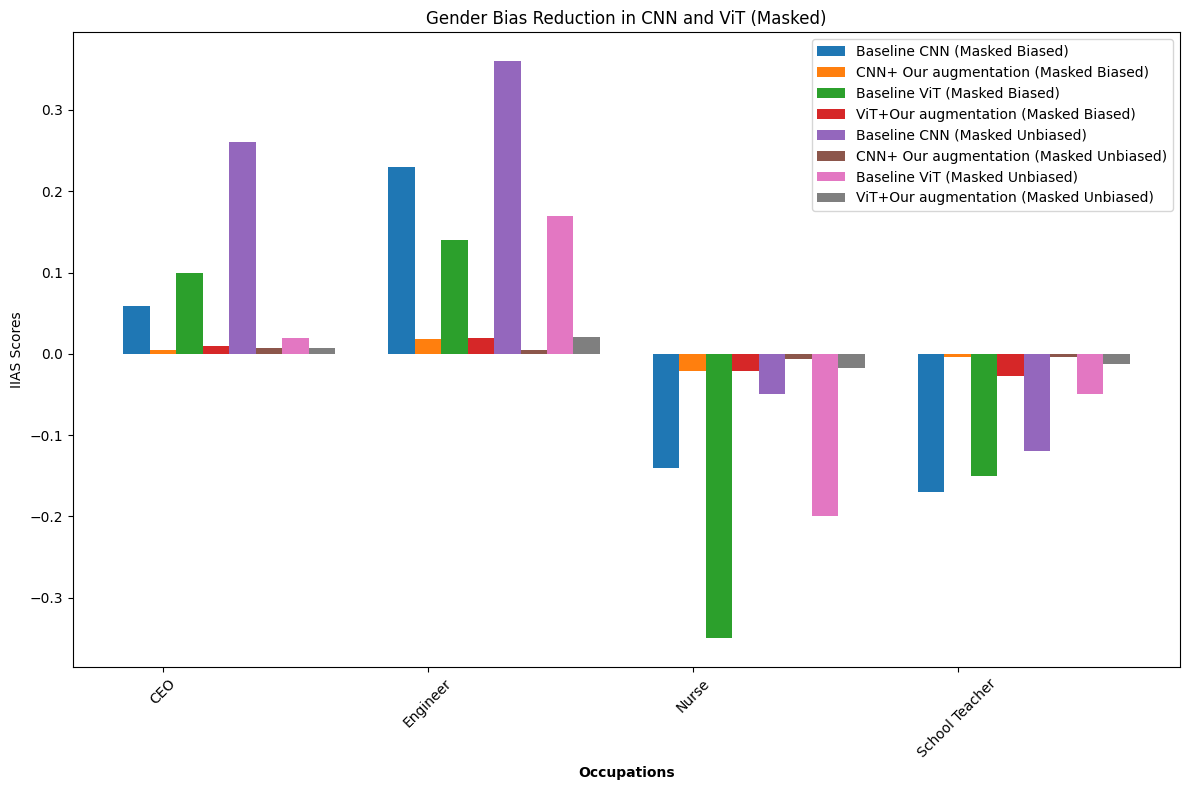

In [ ]:
import matplotlib.pyplot as plt

# Define IIAS scores for each model in the masked scenario
baseline_CNN_masked_biased = [0.059, 0.23, -0.14, -0.17]
ours_CNN_masked_biased = [0.005, 0.018, -0.021, -0.004]
baseline_ViT_masked_biased = [0.1, 0.14, -0.35, -0.15]
ours_ViT_masked_biased = [0.010, 0.019, -0.0214, -0.027]

baseline_CNN_masked_unbiased = [0.26, 0.36, -0.05, -0.12]
ours_CNN_masked_unbiased = [0.007, 0.005, -0.007, -0.004]
baseline_ViT_masked_unbiased = [0.02, 0.17, -0.2, -0.05]
ours_ViT_masked_unbiased = [0.007, 0.021, -0.018, -0.013]

# Setting width of bar
barWidth = 0.1
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']

# Set position of bar on X axis
r1 = range(len(classes))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]


# Make the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, baseline_CNN_masked_biased, width=barWidth, label='Baseline CNN (Masked Biased)')
plt.bar(r2, ours_CNN_masked_biased, width=barWidth,  label='CNN+ Our augmentation (Masked Biased)')
plt.bar(r3, baseline_ViT_masked_biased, width=barWidth,  label='Baseline ViT (Masked Biased)')
plt.bar(r4, ours_ViT_masked_biased, width=barWidth,  label='ViT+Our augmentation (Masked Biased)')
plt.bar(r5, baseline_CNN_masked_unbiased, width=barWidth, label='Baseline CNN (Masked Unbiased)')
plt.bar(r6, ours_CNN_masked_unbiased, width=barWidth, label='CNN+ Our augmentation (Masked Unbiased)')
plt.bar(r7, baseline_ViT_masked_unbiased, width=barWidth, label='Baseline ViT (Masked Unbiased)')
plt.bar(r8, ours_ViT_masked_unbiased, width=barWidth,  label='ViT+Our augmentation (Masked Unbiased)')


# Add xticks on the middle of the group bars
plt.xlabel('Occupations', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(classes))], classes)

# Create legend & Show graphic
plt.legend()
plt.title('Gender Bias Reduction in CNN and ViT (Masked)')
plt.ylabel('IIAS Scores')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('FaceSaliencyAug_gender_masked_reduction.pdf', format='pdf', dpi=1000)
plt.show()

## All Unmasked scenario

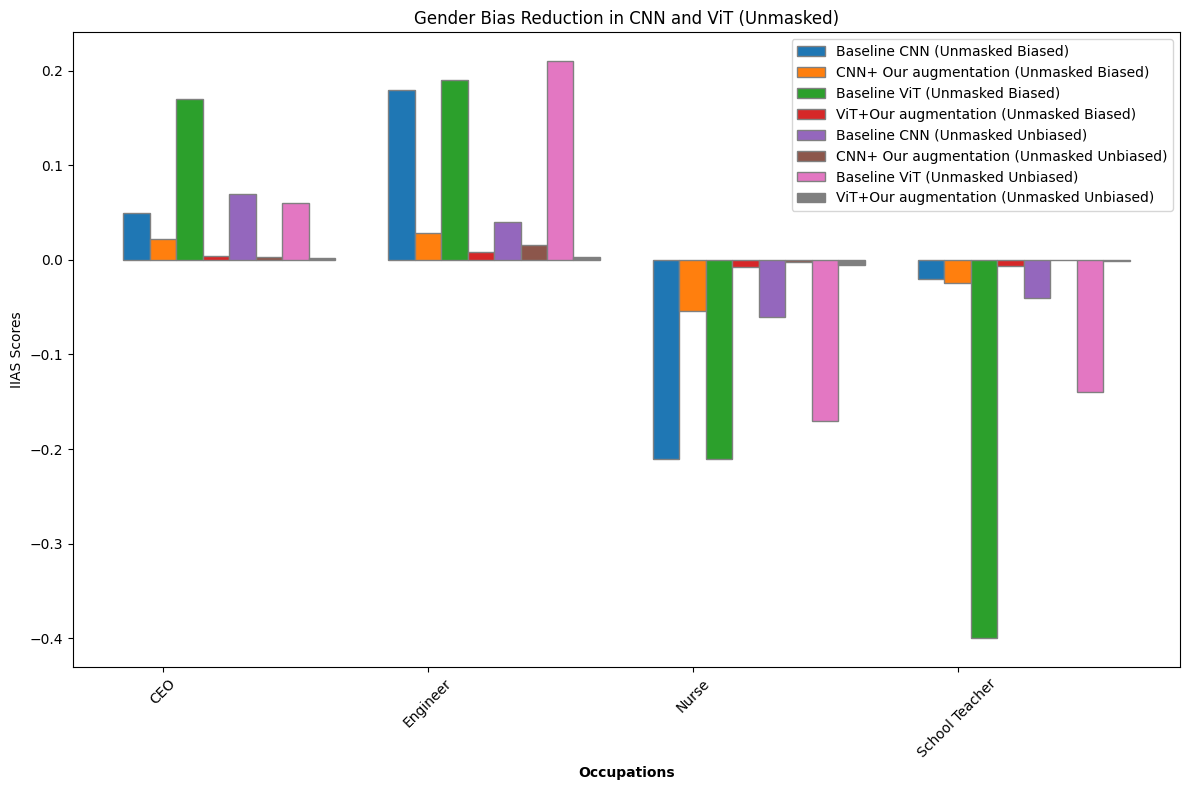

In [ ]:
import matplotlib.pyplot as plt



# # IIAS scores for CNN and ViT in the unmasked biased scenario
# baseline_CNN_unmasked_biased = [0.07, 0.04, -0.06, -0.04]
# ours_CNN_unmasked_biased = [0.03, 0.036, -0.023, -0.056]
# baseline_ViT_unmasked_biased = [0.023, 0.21, -0.17, -0.14]
# ours_ViT_unmasked_biased = [0.059, 0.003, -0.003, -0.036]

# # IIAS scores for CNN and ViT in the unmasked unbiased scenario
# baseline_CNN_unmasked_unbiased = [0.79, 0.21, -0.05, -0.12]
# ours_CNN_unmasked_unbiased = [0.21, 0.145, -0.023, -0.077]
# baseline_ViT_unmasked_unbiased = [0.44, 0.58, -0.17, -0.05]
# ours_ViT_unmasked_unbiased = [0.103, 0.101, -0.003, -0.036]



# biased scenario
baseline_CNN_unmasked_biased = [0.050, 0.180, -0.21, -0.02]
ours_CNN_unmasked_biased = [0.022, 0.028, -0.054, -0.025]
baseline_ViT_unmasked_biased = [0.17, 0.19, -0.21, -0.4]
ours_ViT_unmasked_biased = [0.004, 0.008, -0.008, -0.006]
# Unbiased scenario
baseline_CNN_unmasked_unbiased = [0.07, 0.04, -0.06, -0.04]
ours_CNN_unmasked_unbiased = [0.003, 0.016, -0.002, -0.0002]
baseline_ViT_unmasked_unbiased = [0.06, 0.21, -0.17, -0.14]
ours_ViT_unmasked_unbiased = [0.002, 0.003, -0.005, -0.001]

# Setting width of bar
barWidth = 0.1

# Set position of bar on X axis
r1 = range(len(classes))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]


# Make the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, baseline_CNN_unmasked_biased, width=barWidth, edgecolor='grey', label='Baseline CNN (Unmasked Biased)')
plt.bar(r2, ours_CNN_unmasked_biased, width=barWidth, edgecolor='grey', label='CNN+ Our augmentation (Unmasked Biased)')
plt.bar(r3, baseline_ViT_unmasked_biased, width=barWidth, edgecolor='grey', label='Baseline ViT (Unmasked Biased)')
plt.bar(r4, ours_ViT_unmasked_biased, width=barWidth, edgecolor='grey', label='ViT+Our augmentation (Unmasked Biased)')
plt.bar(r5, baseline_CNN_unmasked_unbiased, width=barWidth, edgecolor='grey', label='Baseline CNN (Unmasked Unbiased)')
plt.bar(r6, ours_CNN_unmasked_unbiased, width=barWidth, edgecolor='grey', label='CNN+ Our augmentation (Unmasked Unbiased)')
plt.bar(r7, baseline_ViT_unmasked_unbiased, width=barWidth, edgecolor='grey', label='Baseline ViT (Unmasked Unbiased)')
plt.bar(r8, ours_ViT_unmasked_unbiased, width=barWidth, edgecolor='grey', label='ViT+Our augmentation (Unmasked Unbiased)')


# Add xticks on the middle of the group bars
plt.xlabel('Occupations', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(classes))], classes)

# Create legend & Show graphic
plt.legend()
plt.title('Gender Bias Reduction in CNN and ViT (Unmasked)')
plt.ylabel('IIAS Scores')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('FaceSaliencyAug_gender_unmasked_reduction.pdf', format='pdf', dpi=1000)
plt.show()


## Each scenario ( Total 4 scenarios)

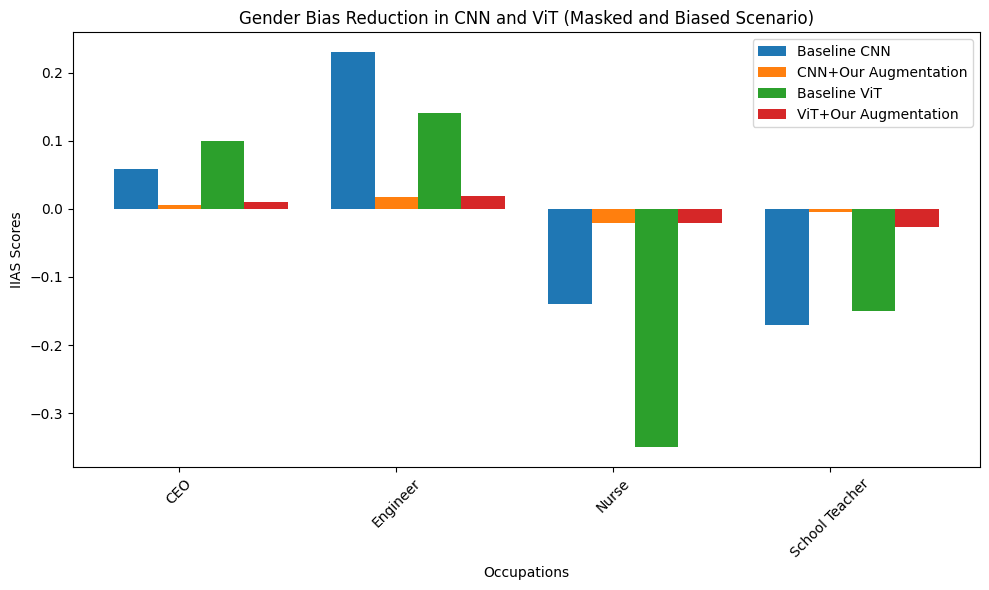

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# IIAS scores for CNN and ViT in the masked scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']

# Define IIAS scores for each model in the masked scenario
baseline_CNN_masked_biased = [0.059, 0.23, -0.14, -0.17]
ours_CNN_masked_biased = [0.005, 0.018, -0.021, -0.004]
baseline_ViT_masked_biased = [0.1, 0.14, -0.35, -0.15]
ours_ViT_masked_biased = [0.010, 0.019, -0.0214, -0.027]

# Set the width of the bars
bar_width = 0.2

# Set the position of each bar on the x-axis
baseline_positions = np.arange(len(classes))
ours_positions = [x + bar_width for x in baseline_positions]

# Plotting for masked scenario
plt.figure(figsize=(10, 6))

plt.bar(baseline_positions, baseline_CNN_masked_biased, bar_width, label='Baseline CNN')
plt.bar(ours_positions, ours_CNN_masked_biased, bar_width, label='CNN+Our Augmentation')

plt.bar([x + 2 * bar_width for x in baseline_positions], baseline_ViT_masked_biased, bar_width, label='Baseline ViT')
plt.bar([x + 3 * bar_width for x in baseline_positions], ours_ViT_masked_biased, bar_width, label='ViT+Our Augmentation')

# Add labels, title, and legend
plt.xlabel('Occupations')
plt.ylabel('IIAS Scores')
plt.title('Gender Bias Reduction in CNN and ViT (Masked and Biased Scenario)')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)  # Remove the grid
plt.tight_layout()
plt.savefig('masked_bias_reduction.pdf', dpi=1000)
# Show the plot
plt.show()


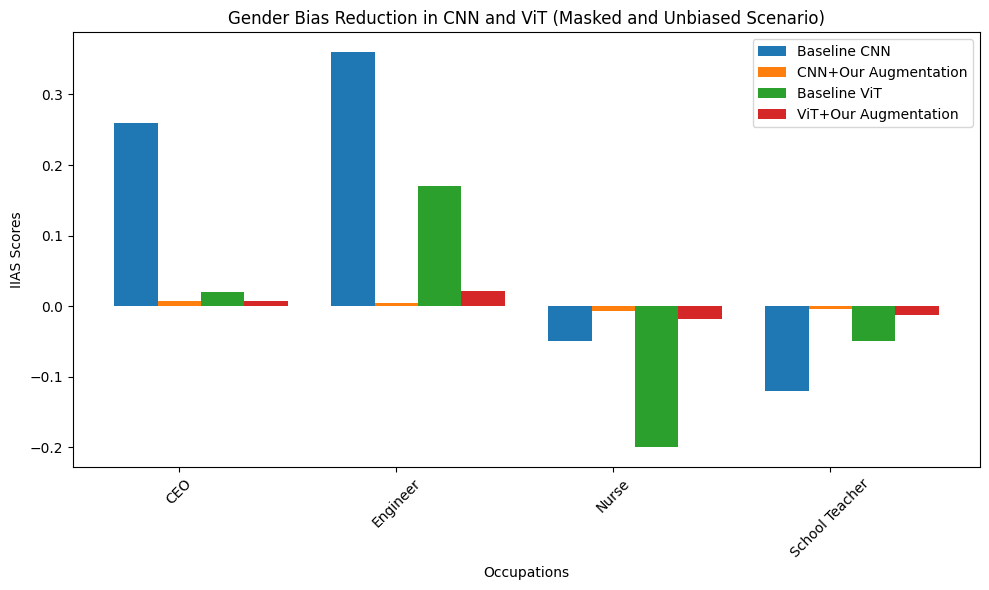

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# IIAS scores for CNN and ViT in the masked scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']



# Unbiased scenario
baseline_CNN_unbiased = [0.26, 0.36, -0.05, -0.12]
ours_CNN_unbiased = [0.007, 0.005, -0.007, -0.004]
baseline_ViT_unbiased = [0.02, 0.17, -0.2, -0.05]
Our_ViT_unbiased = [0.007, 0.021, -0.018, -0.013]
# Set the width of the bars
bar_width = 0.2

# Set the position of each bar on the x-axis
baseline_positions = np.arange(len(classes))
ours_positions = [x + bar_width for x in baseline_positions]

# Plotting for masked scenario
plt.figure(figsize=(10, 6))

plt.bar(baseline_positions, baseline_CNN_unbiased, bar_width, label='Baseline CNN')
plt.bar(ours_positions, ours_CNN_unbiased, bar_width, label='CNN+Our Augmentation')

plt.bar([x + 2 * bar_width for x in baseline_positions], baseline_ViT_unbiased, bar_width, label='Baseline ViT')
plt.bar([x + 3 * bar_width for x in baseline_positions], Our_ViT_unbiased, bar_width, label='ViT+Our Augmentation')

# Add labels, title, and legend
plt.xlabel('Occupations')
plt.ylabel('IIAS Scores')
plt.title('Gender Bias Reduction in CNN and ViT (Masked and Unbiased Scenario)')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)  # Remove the grid
plt.tight_layout()
plt.savefig('masked_Unbias_reduction.pdf', dpi=1000)
# Show the plot
plt.show()


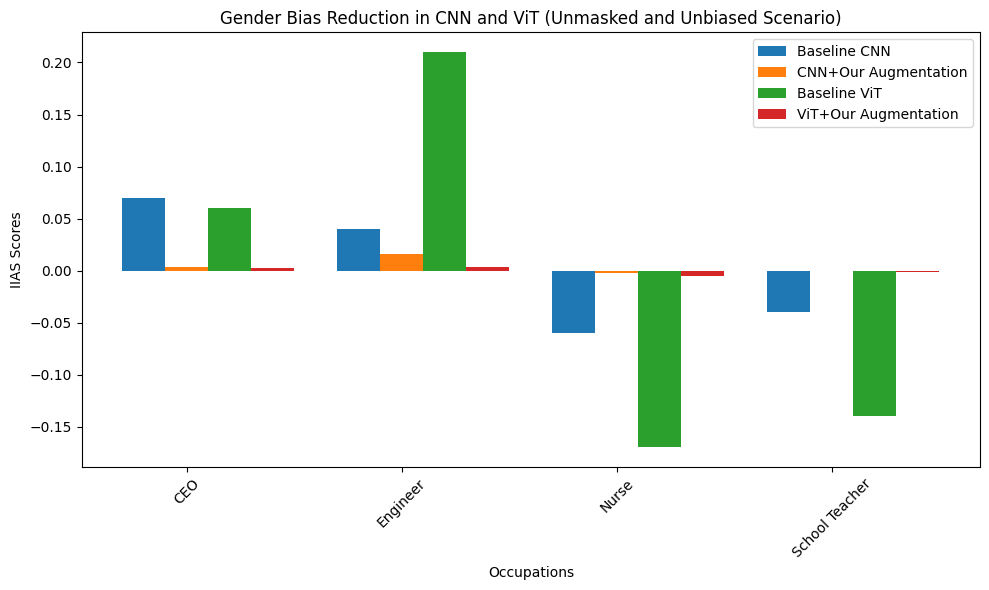

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# IIAS scores for CNN and ViT in the masked scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']




# Unbiased scenario
baseline_CNN_unbiased = [0.07, 0.04, -0.06, -0.04]
ours_CNN_unbiased = [0.003, 0.016, -0.002, -0.0002]
baseline_ViT_unbiased = [0.06, 0.21, -0.17, -0.14]
ours_ViT_unbiased = [0.002, 0.003, -0.005, -0.001]
# Set the width of the bars
bar_width = 0.2

# Set the position of each bar on the x-axis
baseline_positions = np.arange(len(classes))
ours_positions = [x + bar_width for x in baseline_positions]

# Plotting for masked scenario
plt.figure(figsize=(10, 6))

plt.bar(baseline_positions, baseline_CNN_unbiased, bar_width, label='Baseline CNN')
plt.bar(ours_positions, ours_CNN_unbiased, bar_width, label='CNN+Our Augmentation')

plt.bar([x + 2 * bar_width for x in baseline_positions], baseline_ViT_unbiased, bar_width, label='Baseline ViT')
plt.bar([x + 3 * bar_width for x in baseline_positions], ours_ViT_unbiased, bar_width, label='ViT+Our Augmentation')

# Add labels, title, and legend
plt.xlabel('Occupations')
plt.ylabel('IIAS Scores')
plt.title('Gender Bias Reduction in CNN and ViT (Unmasked and Unbiased Scenario)')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)  # Remove the grid
plt.tight_layout()
plt.savefig('Unmasked_Unbias_reduction.pdf', dpi=1000)
# Show the plot
plt.show()


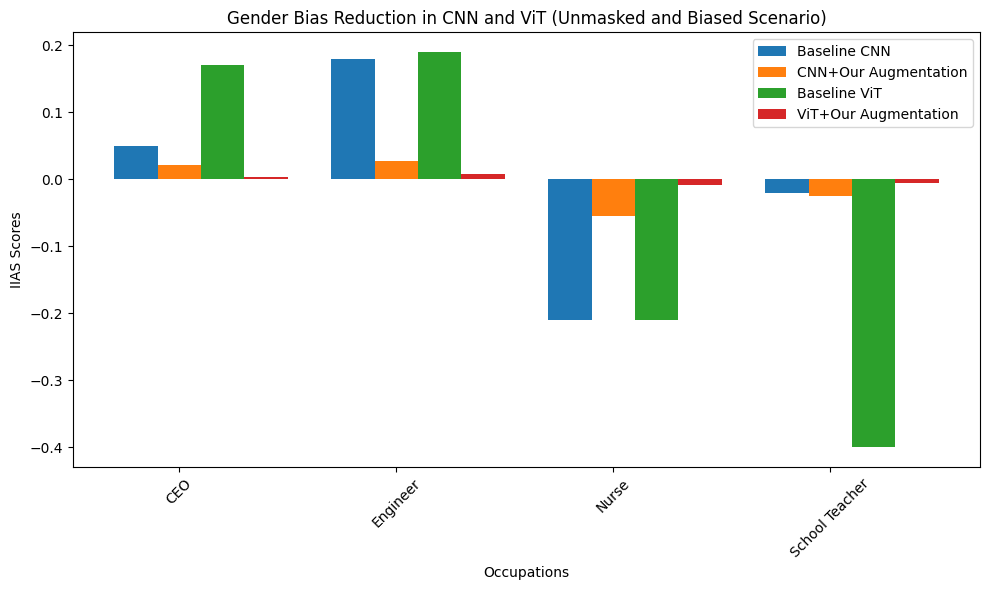

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# IIAS scores for CNN and ViT in the masked scenario
classes = ['CEO', 'Engineer', 'Nurse', 'School Teacher']



# Unbiased scenario

# Unbiased scenario


baseline_CNN_biased = [0.050, 0.180, -0.21, -0.02]
ours_CNN_biased = [0.022, 0.028, -0.054, -0.025]
baseline_ViT_biased = [0.17, 0.19, -0.21, -0.4]
ours_ViT_biased = [0.004, 0.008, -0.008, -0.006]


# Set the width of the bars
bar_width = 0.2

# Set the position of each bar on the x-axis
baseline_positions = np.arange(len(classes))
ours_positions = [x + bar_width for x in baseline_positions]

# Plotting for masked scenario
plt.figure(figsize=(10, 6))

plt.bar(baseline_positions, baseline_CNN_biased, bar_width, label='Baseline CNN')
plt.bar(ours_positions, ours_CNN_biased, bar_width, label='CNN+Our Augmentation')

plt.bar([x + 2 * bar_width for x in baseline_positions], baseline_ViT_biased, bar_width, label='Baseline ViT')
plt.bar([x + 3 * bar_width for x in baseline_positions], ours_ViT_biased, bar_width, label='ViT+Our Augmentation')

# Add labels, title, and legend
plt.xlabel('Occupations')
plt.ylabel('IIAS Scores')
plt.title('Gender Bias Reduction in CNN and ViT (Unmasked and Biased Scenario)')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)  # Remove the grid
plt.tight_layout()
plt.savefig('Unmasked_bias_reduction.pdf', dpi=1000)
# Show the plot
plt.show()
# Define IIAS scores for each model and scenario
# Biased scenario
